In [1]:
#! pip install -U pip setuptools wheel
#! pip install -U 'spacy[cuda12x]'
#! python -m spacy download en_core_web_trf
#! python -m spacy download en_core_web_sm
#! pip install pandas

### Baixar CSV DAtaset

Para realizar o tratamento de dados a seguir, o IMDB Dataset deve ser baixado, e colocado na pasta raiz do projeto

<a href="https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" target="_blank">Conjunto de dados IMDB de 50 mil críticas de filmes</a>


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from spacy.tokens import Doc
from tqdm import tqdm

In [20]:
# Carregar o modelo em inglês
# nlp = spacy.load("en_core_web_trf", exclude=["parser", "ner"])
nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])
FILE_PATH = "D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/scrapper_reviews_english_original.csv"
df = pd.read_csv(FILE_PATH)
df = df[['review','rating']]
# df = df[:1000]

In [22]:
print(df['rating'].value_counts())
df


rating
10    6236
8     6225
9     6222
7     5800
6     4649
5     3741
1     3446
4     2962
3     2726
2     2420
Name: count, dtype: int64


,review,rating
0,This movie takes place off in fantasy land som...,1
1,"Too sentimental, too pathetic, too slow, too c...",1
2,There are some things in this life we will nev...,1
3,This movie was inspired by the brilliant Stir ...,1
4,"For the life of me, I can't understand all the...",1
...,...,...
44422,"Uma Thurman returns as the Bride, who this tim...",10
44423,"Quentin Tarantino's ""Kill Bill: Vol. 2"" comple...",10
44424,Vol 2 is completely different tone then the fi...,10
44425,This movie is great in that it mixes together ...,10


In [5]:
df["rating"].value_counts()

rating
10    6236
8     6225
9     6222
7     5800
6     4649
5     3741
1     3446
4     2962
3     2726
2     2420
Name: count, dtype: int64

In [6]:
df.isnull().sum()

review    0
rating    0
dtype: int64

In [7]:
df.duplicated().sum()

16

In [8]:
# Remove linhas de reviews_treated duplicadoss
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df["rating"].value_counts()

rating
10    6231
8     6225
9     6217
7     5799
6     4649
5     3741
1     3443
4     2960
3     2726
2     2420
Name: count, dtype: int64

In [11]:
def obter_maior_texto(df):
    return max(df["review"], key=lambda x: len(x.split()))

In [12]:
maior_string = obter_maior_texto(df)
tam_maior_string = len(maior_string)
print(tam_maior_string)

9942


In [13]:
# Calcular o tamanho dos textos
df['text_length'] = df['review'].apply(len)

In [14]:
df['text_length'].value_counts()

text_length
644     53
672     52
671     52
664     49
641     49
        ..
5186     1
5894     1
7435     1
6627     1
8262     1
Name: count, Length: 5152, dtype: int64

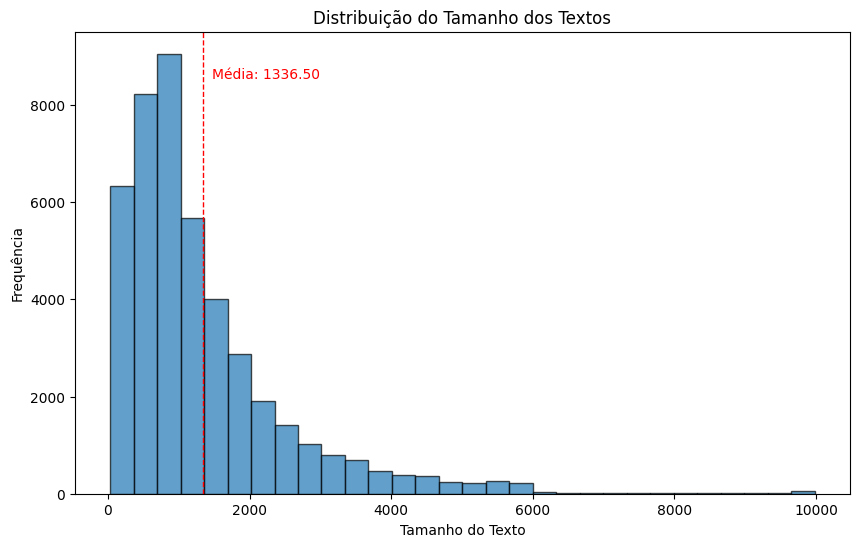

In [15]:
# Calcular o tamanho dos textos
df['text_length'] = df['review'].apply(len)
# Calcular a média do tamanho dos textos
mean_length = df['text_length'].mean()

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length:.2f}', color='r')
plt.title('Distribuição do Tamanho dos Textos')
plt.xlabel('Tamanho do Texto')
plt.ylabel('Frequência')
plt.show()

In [16]:
# funcoes de tratamento comuns
def remove_extra_spaces(text):
    r"Remover espacos, quebra de linhas e tabulações do inicio e fim de frases e ubstituir sequências de espaços por um espaço"
    return re.sub(r"\s+", " ", text).strip()
    


def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile("<.*?>"), "", raw_text)
    return cleaned_text


def normalize_lowercase(text: str) -> str:
    return text.lower()


# funcoes de tratamento spacy
def lemmatize_text_remove_stopwords_and_puntuaction(doc: Doc | str):
    if not isinstance(doc, Doc):
        doc = nlp(doc)
    return " ".join(
        [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    )


def remove_stopwords_and_puntuaction(doc: Doc | str):
    if not isinstance(doc, Doc):
        doc = nlp(doc)
    return " ".join(
        [token.text for token in doc if not token.is_stop and not token.is_punct]
    )


# def remove_punctuation(doc):
#     return " ".join([token.text for token in doc if not token.is_punct])


# def remove_stopwords(doc):
#     return " ".join([token.text for token in doc if not token.is_stop])


# def lemmatize_text(doc):
#     return " ".join([token.lemma_ for token in doc])

In [17]:
def execute_all_trataments(series_review, FINAL_SPACY_FORMAT):
    reviews_treated = df["review"]

    reviews_treated = reviews_treated.apply(remove_tags)
    reviews_treated = reviews_treated.apply(normalize_lowercase)
    reviews_treated = reviews_treated.apply(remove_extra_spaces)

    len_texts = len(reviews_treated)
    docs = list(
        tqdm(
            nlp.pipe(
                reviews_treated,
                batch_size=500,
                disable=["parser", "ner"],
            ),
            colour="green",
            desc="Progresso: ",
            total=len_texts,
        )
    )

    if FINAL_SPACY_FORMAT == "lemma":
        reviews_treated = [
            lemmatize_text_remove_stopwords_and_puntuaction(doc) for doc in docs
        ]
    elif FINAL_SPACY_FORMAT == "text":
        reviews_treated = [remove_stopwords_and_puntuaction(doc) for doc in docs]
    reviews_treated = [remove_extra_spaces(review) for review in reviews_treated]
    return reviews_treated

In [18]:
# Aplicar as funções de str ao DataFrame
# definir como True para saída em forma de token.lemma, ou False para token.text
FINAL_SPACY_FORMAT= "text" 
reviews_treated= execute_all_trataments(df["review"],FINAL_SPACY_FORMAT)

Progresso:  55%|█████▌    | 24466/44411 [06:52<05:36, 59.28it/s]  


KeyboardInterrupt: 

In [ ]:
df["review"]= reviews_treated

In [ ]:
df


,review,rating,text_length
0,movie takes place fantasy land absolutely ridi...,1,358
1,sentimental pathetic slow conventionally voice...,1,198
2,things life understand universe begin happens ...,1,1692
3,movie inspired brilliant stir crazy starring g...,1,786
4,life understand gushing cornball sentimental p...,1,460
...,...,...,...
44422,uma thurman returns bride time looks continue ...,10,1409
44423,quentin tarantino kill bill vol 2 completes 2 ...,10,3680
44424,vol 2 completely different tone features film ...,10,219
44425,movie great mixes different genres movies mart...,10,634


In [ ]:
maior_string = obter_maior_texto(df)
tam_maior_string= len(maior_string)
print(tam_maior_string)

6280


In [ ]:
df.duplicated().sum()

1

In [ ]:
df = df.drop_duplicates(ignore_index=True)
df.duplicated().sum()

0

In [ ]:
df=df.drop(columns=['text_length'])

In [ ]:
DATA_PATH= f"D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_{FINAL_SPACY_FORMAT}.csv"
df.to_csv(DATA_PATH, index=False)

## Vizualizacao dos dados após tratamento

carregar csv já tratado


In [24]:
import pandas as pd
DATA_PATH= f"D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_text.csv"
# DATA_PATH= f"D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_lemma.csv"
df = pd.read_csv(DATA_PATH)

In [ ]:
import pandas as pd

# Número de avaliações
num_reviews = df['review'].count()

# Número médio de caracteres por avaliação
avg_chars = df['review'].apply(len).mean()

# Número médio de palavras por avaliação
avg_words = df['review'].apply(lambda x: len(x.split())).mean()

print(f"Número de avaliações: {num_reviews}")
print(f"Número médio de caracteres por avaliação: {avg_chars:.2f}")
print(f"Número médio de palavras por avaliação: {avg_words:.2f}")


Número de avaliações: 44410
Número médio de caracteres por avaliação: 778.85
Número médio de palavras por avaliação: 107.26


In [ ]:
import collections

# Concatenar todas as avaliações em uma única string
all_reviews = ' '.join(df['review'])

# Dividir a string em palavras
words = all_reviews.split()

# Contar a frequência de cada palavra
word_counts = collections.Counter(words)

# Exibir as 10 palavras mais comuns
for word, count in word_counts.most_common(-10):
    print(f'Palavra: {word}, Frequência: {count}')

# len(word_counts)

In [ ]:
import numpy as np

# Calcular estatísticas básicas
frequencies = list(word_counts.values())
mean_freq = np.mean(frequencies)
median_freq = np.median(frequencies)
min_freq = np.min(frequencies)
max_freq = np.max(frequencies)
std_freq = np.std(frequencies)

print(f"Média de frequência: {mean_freq}")
print(f"Mediana de frequência: {median_freq}")
print(f"Frequência mínima: {min_freq}")
print(f"Frequência máxima: {max_freq}")
print(f"Desvio padrão de frequência: {std_freq}")

# Calcular o IQR
Q1 = np.percentile(frequencies, 25)
Q3 = np.percentile(frequencies, 75)
IQR = Q3 - Q1

# Identificar outliers
outliers = [freq for freq in frequencies if freq < Q1 - 1.5 * IQR or freq > Q3 + 1.5 * IQR]

print(f"Número de outliers: {len(outliers)}")


Média de frequência: 31.72152707949044
Mediana de frequência: 1.0
Frequência mínima: 1
Frequência máxima: 87252
Desvio padrão de frequência: 426.00182866206455
Número de outliers: 28201


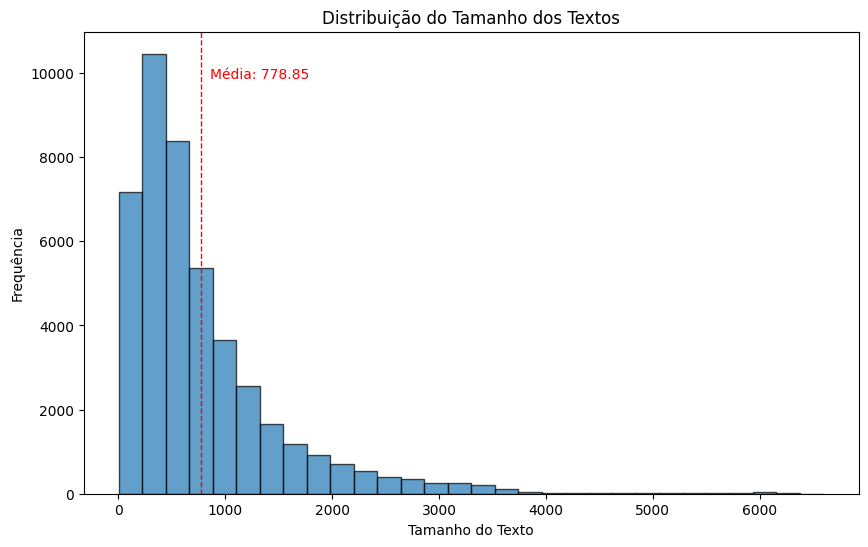

In [ ]:
# Calcular o tamanho dos textos
df['text_length'] = df['review'].apply(len)

# Calcular a média do tamanho dos textos
mean_length = df['text_length'].mean()

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length:.2f}', color='r')
plt.title('Distribuição do Tamanho dos Textos')
plt.xlabel('Tamanho do Texto')
plt.ylabel('Frequência')
plt.show()

## 1. Escala Logarítmica
Usar uma escala logarítmica no eixo x pode ajudar a visualizar melhor a distribuição dos tamanhos dos textos.

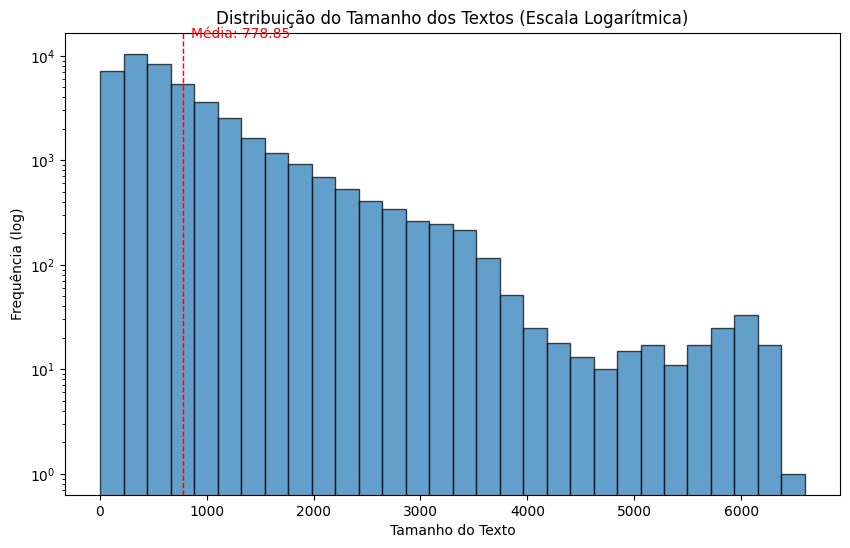

In [ ]:
# Plotar o gráfico com escala logarítmica
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, edgecolor='k', alpha=0.7, log=True)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length:.2f}', color='r')
plt.title('Distribuição do Tamanho dos Textos (Escala Logarítmica)')
plt.xlabel('Tamanho do Texto')
plt.ylabel('Frequência (log)')
plt.show()

## 2. Remoção de Outliers
Remover textos que estão muito longe da média (por exemplo, além de 3 desvios padrão) pode ajudar a focar na distribuição central dos dados.

método de remoção de outliers do Intervalo Interquartil (IQR)

IQR 659.0


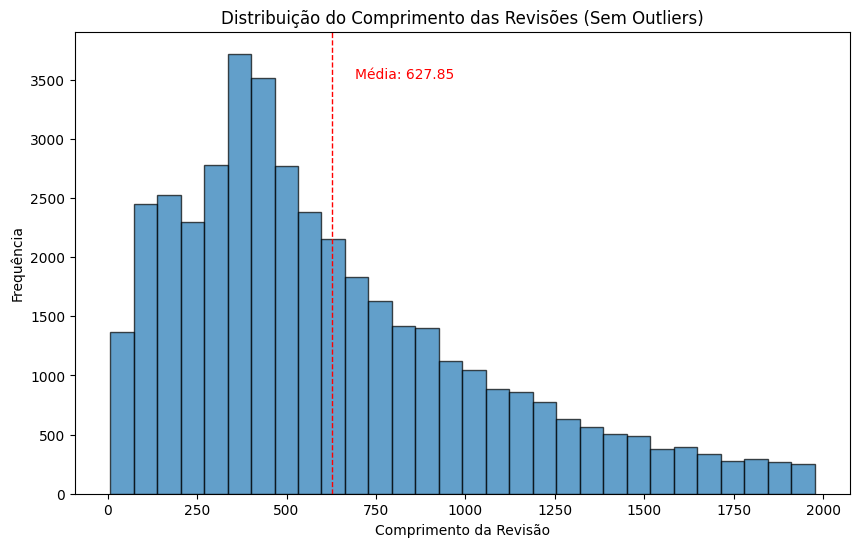

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
DATA_PATH= f"D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_text.csv"
df = pd.read_csv(DATA_PATH)

# Calcular o comprimento de cada revisão
df["review_length"] = df["review"].apply(len)

# Calcular o IQR
Q1 = df["review_length"].quantile(0.25)
Q3 = df["review_length"].quantile(0.75)
IQR = Q3 - Q1
print("IQR",IQR)
# Definir os limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remover outliers
df_filtered = df[
    (df["review_length"] >= lower_bound) & (df["review_length"] <= upper_bound)
]


# Calcular a média dos comprimentos das revisões
mean_length = df_filtered['review_length'].mean()

# Plotar um histograma dos comprimentos das revisões
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['review_length'], bins=30, edgecolor='k', alpha=0.7)

# Adicionar uma linha vertical para a média
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length:.2f}', color='r')

plt.title('Distribuição do Comprimento das Revisões (Sem Outliers)')
plt.xlabel('Comprimento da Revisão')
plt.ylabel('Frequência')
plt.show()



In [56]:
df_filtered['review_length'].describe()


count    40125.000000
mean       591.938916
std        389.459590
min          7.000000
25%        307.000000
50%        498.000000
75%        826.000000
max       1698.000000
Name: review_length, dtype: float64

In [57]:
df_filtered['rating'].value_counts()


rating
8     5394
9     5300
7     5272
10    5169
6     4331
5     3530
1     3353
4     2801
3     2623
2     2352
Name: count, dtype: int64

In [58]:
df_filtered.head(0)

,review,rating,review_length


In [52]:
df_filtered=df_filtered.drop(columns=['review_length'],)

### Salvar CSV sem outliers

In [53]:
DATA_PATH= f"D:/tcc2/guilherme/2-tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_text_without_outliers.csv"
df_filtered.to_csv(DATA_PATH,index=False)

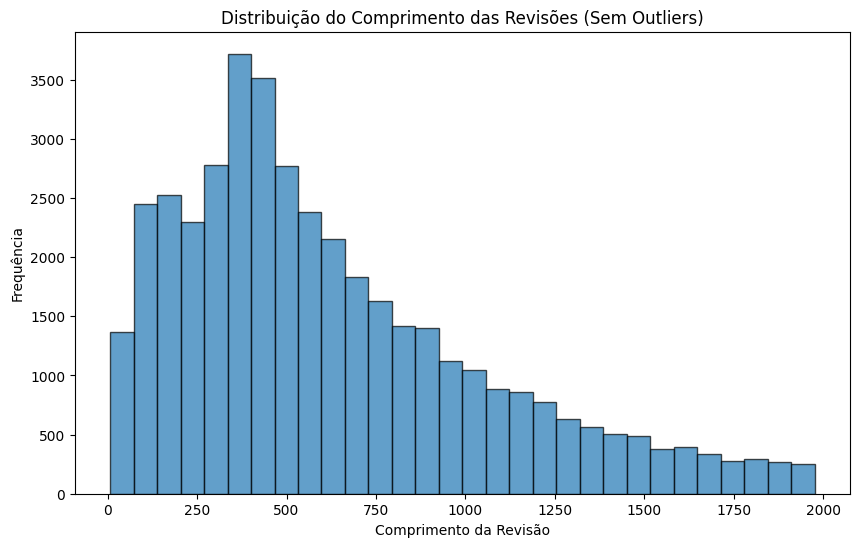

In [34]:
import matplotlib.pyplot as plt

# Plotar um histograma dos comprimentos das revisões
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['review_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribuição do Comprimento das Revisões (Sem Outliers)')
plt.xlabel('Comprimento da Revisão')
plt.ylabel('Frequência')
plt.show()


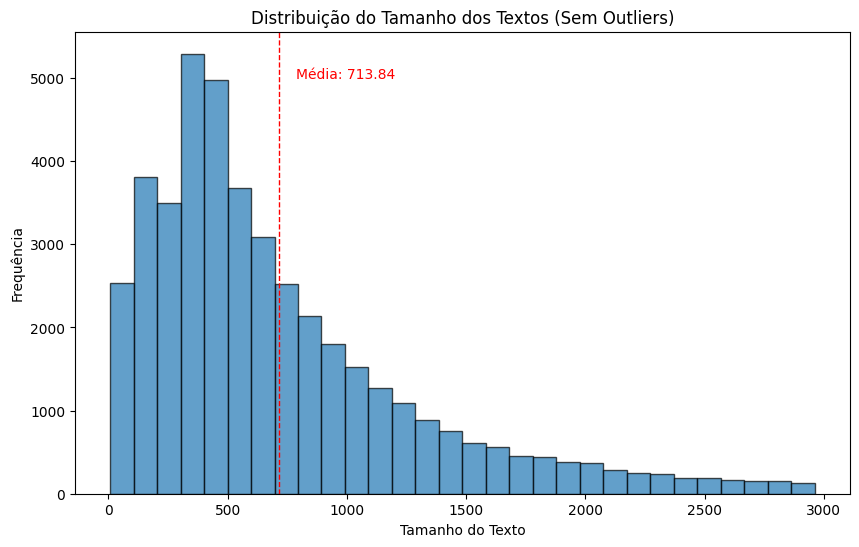

Distribuição do Tamanho dos Textos (Sem Outliers)
Média do tamanho dos textos: 713.84
Limite inferior para remoção de outliers: -1405.98
Limite superior para remoção de outliers: 2963.67
Total de textos considerados: 43455


In [ ]:
import numpy as np


# Calcular o tamanho dos textos
df['text_length'] = df['review'].apply(len)

# Calcular a média e o desvio padrão
mean_length = df['text_length'].mean()
std_length = df['text_length'].std()

# Definir o limite para remoção de outliers (por exemplo, 3 desvios padrão)
threshold_min = mean_length - 3 * std_length
threshold_max = mean_length + 3 * std_length

# Filtrar os textos dentro do limite
df_filtered = df[(df['text_length'] >= threshold_min) & (df['text_length'] <= threshold_max)]

# Calcular a nova média
mean_length_filtered = df_filtered['text_length'].mean()

# Plotar o gráfico sem outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(mean_length_filtered, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length_filtered*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length_filtered:.2f}', color='r')
plt.title('Distribuição do Tamanho dos Textos (Sem Outliers)')
plt.xlabel('Tamanho do Texto')
plt.ylabel('Frequência')
plt.show()

result_string = (
    f"Distribuição do Tamanho dos Textos (Sem Outliers)\n"
    f"Média do tamanho dos textos: {mean_length_filtered:.2f}\n"
    f"Limite inferior para remoção de outliers: {threshold_min:.2f}\n"
    f"Limite superior para remoção de outliers: {threshold_max:.2f}\n"
    f"Total de textos considerados: {len(df_filtered)}"
)

print(result_string)

Aqui está um exemplo ajustado usando quantis para remover outliers:

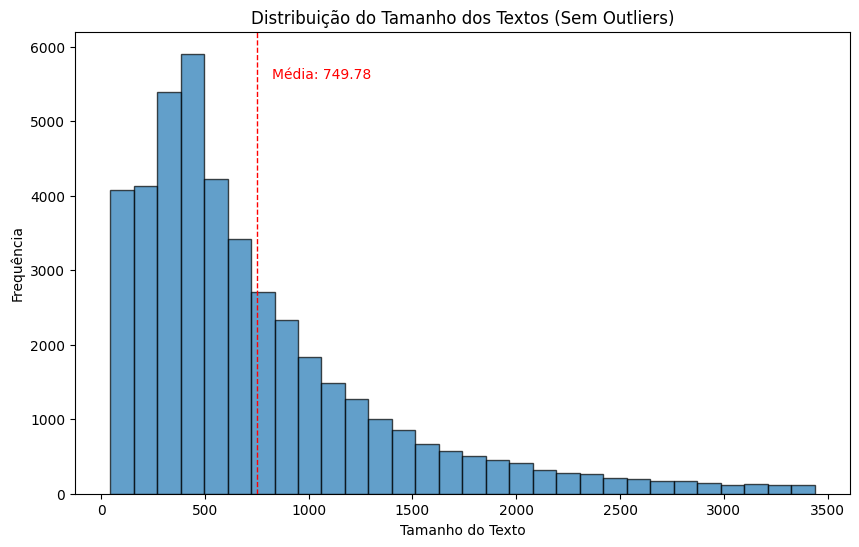

Distribuição do Tamanho dos Textos (Sem Outliers)
Média do tamanho dos textos: 749.78
Limite inferior para remoção de outliers: 43.00
Limite superior para remoção de outliers: 3442.55
Total de textos considerados: 43528


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o DataFrame

# Remover valores nulos
df.dropna(subset=['review'], inplace=True)

# Calcular o tamanho dos textos
df['text_length'] = df['review'].apply(len)

# Definir os limites para remoção de outliers usando quantis (por exemplo, 1% e 99%)
q_low = df['text_length'].quantile(0.01)
q_high = df['text_length'].quantile(0.99)

# Filtrar os textos dentro dos limites
df_filtered = df[(df['text_length'] >= q_low) & (df['text_length'] <= q_high)]

# Calcular a nova média
mean_length_filtered = df_filtered['text_length'].mean()

# Plotar o gráfico sem outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(mean_length_filtered, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length_filtered*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length_filtered:.2f}', color='r')
plt.title('Distribuição do Tamanho dos Textos (Sem Outliers)')
plt.xlabel('Tamanho do Texto')
plt.ylabel('Frequência')
plt.show()

# Converter o resultado do gráfico em uma string
result_string = (
    f"Distribuição do Tamanho dos Textos (Sem Outliers)\n"
    f"Média do tamanho dos textos: {mean_length_filtered:.2f}\n"
    f"Limite inferior para remoção de outliers: {q_low:.2f}\n"
    f"Limite superior para remoção de outliers: {q_high:.2f}\n"
    f"Total de textos considerados: {len(df_filtered)}"
)

print(result_string)


In [ ]:
df

,review,rating,text_length
0,movie takes place fantasy land absolutely ridi...,1,201
1,sentimental pathetic slow conventionally voice...,1,118
2,things life understand universe begin happens ...,1,887
3,movie inspired brilliant stir crazy starring g...,1,524
4,life understand gushing cornball sentimental p...,1,266
...,...,...,...
44405,uma thurman returns bride time looks continue ...,10,851
44406,quentin tarantino kill bill vol 2 completes 2 ...,10,2391
44407,vol 2 completely different tone features film ...,10,100
44408,movie great mixes different genres movies mart...,10,377


In [ ]:
df_filtered['rating'].value_counts()

rating
9     6101
8     6076
10    6020
7     5713
6     4598
5     3681
1     3372
4     2902
3     2682
2     2383
Name: count, dtype: int64

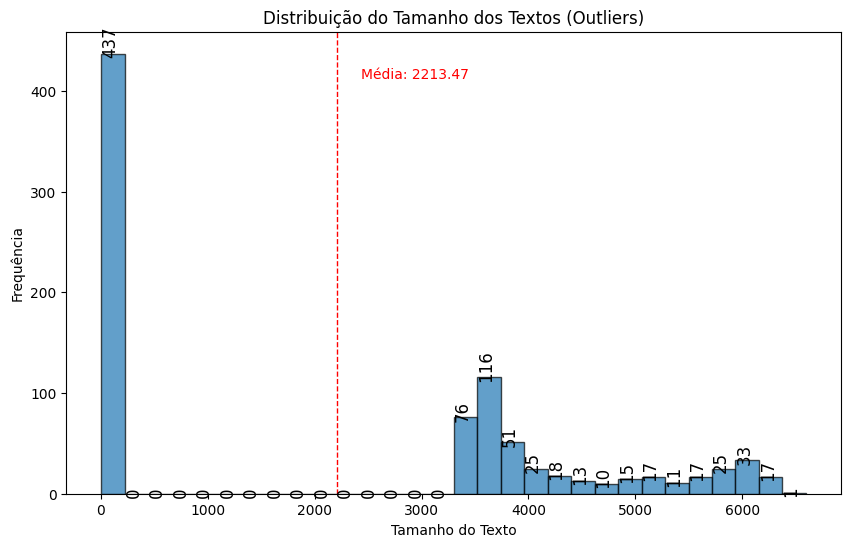

Distribuição do Tamanho dos Textos (Outliers)
Média do tamanho dos textos: 2213.47
Limite inferior para detecção de outliers: 43.00
Limite superior para detecção de outliers: 3442.55
Total de textos considerados outliers: 882


In [ ]:
# Filtrar os textos fora dos limites (ou seja, outliers)
df_outliers = df[(df['text_length'] < q_low) | (df['text_length'] > q_high)]

# Calcular a média dos outliers
mean_length_outliers = df_outliers['text_length'].mean()
# Plotar o gráfico com outliers
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df_outliers['text_length'], bins=30, edgecolor='k', alpha=0.7)

# Adicionar o valor acima de cada barra
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(bin, height, str(int(count)), fontsize=12, ha='left', rotation=90)

plt.axvline(mean_length_outliers, color='r', linestyle='dashed', linewidth=1)
plt.text(mean_length_outliers*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length_outliers:.2f}', color='r')
plt.title('Distribuição do Tamanho dos Textos (Outliers)')
plt.xlabel('Tamanho do Texto')
plt.ylabel('Frequência')
plt.show()

# # Plotar o gráfico com outliers
# plt.figure(figsize=(10, 6))
# plt.hist(df_outliers['text_length'], bins=30, edgecolor='k', alpha=0.7)
# plt.axvline(mean_length_outliers, color='r', linestyle='dashed', linewidth=1)
# plt.text(mean_length_outliers*1.1, plt.ylim()[1]*0.9, f'Média: {mean_length_outliers:.2f}', color='r')
# plt.title('Distribuição do Tamanho dos Textos (Outliers)')
# plt.xlabel('Tamanho do Texto')
# plt.ylabel('Frequência')
# plt.show()

# Converter o resultado do gráfico em uma string
result_string = (
    f"Distribuição do Tamanho dos Textos (Outliers)\n"
    f"Média do tamanho dos textos: {mean_length_outliers:.2f}\n"
    f"Limite inferior para detecção de outliers: {q_low:.2f}\n"
    f"Limite superior para detecção de outliers: {q_high:.2f}\n"
    f"Total de textos considerados outliers: {len(df_outliers)}"
)

print(result_string)
